In [1]:
import cfgrib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_undirected
from torch.utils.data import DataLoader

sys.path.append('..')
from baselines.data_processor import DataProcessor

/home/kamil/Desktop/git/meteoapp-data/venv/lib/python3.11/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.30.0
  warnings.warn(


In [2]:
grib_data = cfgrib.open_datasets('../data2022.grib')
surface = grib_data[0] 
hybrid = grib_data[1] 

In [3]:
# feature_list = ['t2m', 'sp', 'tcc', 'u10', 'v10', 'tp']
# t2m = surface.t2m.to_numpy() - 273.15  # -> C
# sp = surface.sp.to_numpy() / 100       # -> hPa
# tcc = surface.tcc.to_numpy()
# u10 = surface.u10.to_numpy()
# v10 = surface.v10.to_numpy()
# tp = hybrid.tp.to_numpy().reshape((-1,) + hybrid.tp.shape[2:])
# data = np.stack((t2m, sp, tcc, u10, v10, tp), axis=-1)

In [4]:
INPUT_SIZE = 4
BATCH_SIZE = 4
FH = 1

In [5]:
t2m_numpy = surface.t2m.to_numpy()
sp_numpy = surface.sp.to_numpy()
data = np.stack((t2m_numpy, sp_numpy), axis=-1)
print(data.shape)

(1432, 25, 45, 2)


In [6]:
processor = DataProcessor(data)
processor.create_autoregressive_sequences(INPUT_SIZE)
data = processor.data
print(data.shape)
data = data[:10].astype('float32')
_, num_latitudes, num_longitudes, _, num_features = data.shape
data = data.transpose((0, 3, 1, 2, 4))
print(data.shape)
data = data.reshape((-1, INPUT_SIZE, num_latitudes * num_longitudes, num_features))
print(data.shape)

(1429, 25, 45, 4, 2)
(10, 4, 25, 45, 2)
(10, 4, 1125, 2)


In [7]:
def node_index(i, j, num_cols):
    return i * num_cols + j

edge_index = []
for i in range(num_latitudes):
    for j in range(num_longitudes):
        if i > 0:
            edge_index.append([node_index(i, j, num_longitudes), node_index(i - 1, j, num_longitudes)])
        if j > 0:
            edge_index.append([node_index(i, j, num_longitudes), node_index(i, j - 1, num_longitudes)])
            
edge_index = torch.tensor(edge_index, dtype=torch.long).t()
print(edge_index.size())
edge_index = to_undirected(edge_index)
print(edge_index.size())

torch.Size([2, 2180])
torch.Size([2, 4360])


In [8]:
N = 5

class WeatherGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(WeatherGNN, self).__init__()
        self.gconv1 = GCNConv(input_dim, hidden_dim)
        self.gconvs = nn.ModuleList([GCNConv(hidden_dim, hidden_dim) for _ in range(N)])
        self.conv1x1 = nn.Conv2d(in_channels=INPUT_SIZE-1, out_channels=1, kernel_size=1)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc2 = nn.Linear(hidden_dim//2, output_dim)
        
    def forward(self, x, edge_index):
        x = self.gconv1(x, edge_index).relu()
        for gconv in self.gconvs:
            x = gconv(x, edge_index).relu()
        x = self.conv1x1(x).relu()
        x = self.fc1(x).relu()
        x = self.fc2(x)
        return x
    
input_dim = num_features
hidden_dim = 512
output_dim = num_features * FH
model = WeatherGNN(input_dim, hidden_dim, output_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)
edge_index = edge_index.to(device)
data = torch.from_numpy(data).to(device)

train_ratio = 0.7
num_samples = data.shape[0]
train_size = int(train_ratio * num_samples)
train_data, val_data = data[:train_size], data[train_size:]

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
# inputs.dtype, edge_index.dtype, batch.dtype

In [11]:
num_epochs = 100
val_loss_list = []
train_loss_list = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)
        inputs = batch[:, :INPUT_SIZE-FH, ...]
        targets = batch[:, INPUT_SIZE-FH:, ...]
        output = model(inputs, edge_index)
        loss = criterion(output, targets) 
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # if (epoch+1) % 10 == 0:
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch + 1}/{num_epochs}\nTrain Loss: {avg_loss:.4f}")
    train_loss_list.append(avg_loss)
    
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch in val_loader:
            batch = batch.to(device)
            inputs = batch[:, :INPUT_SIZE-FH, ...]
            targets = batch[:, INPUT_SIZE-FH:, ...]
            output = model(inputs, edge_index)
            loss = criterion(output, targets)
            val_loss += loss.item()
       
    # if (epoch+1) % 10 == 0:
    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f"Val Loss: {avg_val_loss:.4f}\n---------")
    val_loss_list.append(avg_val_loss)


Epoch 1/100
Train Loss: 4257200566.8571
Val Loss: 1599140522.6667
---------
Epoch 2/100
Train Loss: 1368986185.1429
Val Loss: 656646613.3333
---------
Epoch 3/100
Train Loss: 3939841298.2857
Val Loss: 684326144.0000
---------
Epoch 4/100
Train Loss: 931254107.4286
Val Loss: 1572367360.0000
---------
Epoch 5/100
Train Loss: 1379960758.8571
Val Loss: 1593413461.3333
---------
Epoch 6/100
Train Loss: 1384185051.4286
Val Loss: 1491227136.0000
---------
Epoch 7/100
Train Loss: 1211573138.2857
Val Loss: 1006427648.0000
---------
Epoch 8/100
Train Loss: 931649097.1429
Val Loss: 535843626.6667
---------
Epoch 9/100
Train Loss: 441462473.1429
Val Loss: 356642645.3333
---------
Epoch 10/100
Train Loss: 310209307.4286
Val Loss: 427120170.6667
---------
Epoch 11/100
Train Loss: 211686961.1429
Val Loss: 57703141.3333
---------
Epoch 12/100
Train Loss: 70421250.2857
Val Loss: 124270506.6667
---------
Epoch 13/100
Train Loss: 125731862.8571
Val Loss: 149838720.0000
---------
Epoch 14/100
Train Loss: 

In [12]:
# train loss 100 epochs

# 2 gconv x 4096
# 7640564150 -> 2980025

# 6 gconv x 512
# 46339536164 -> 8629922

# 20 convs x 512 (more stable ?)
# 1400531602 -> 1339416210

# 10 convs x 512
# nic sie nie uczy XD

# 20 convs x 1024
# tez sie nie uczy?

# 6 convs x 4096; s = 2
# 1523925472900908288 -> 5788668

# czasem sie uczy a czasem wcale xd?

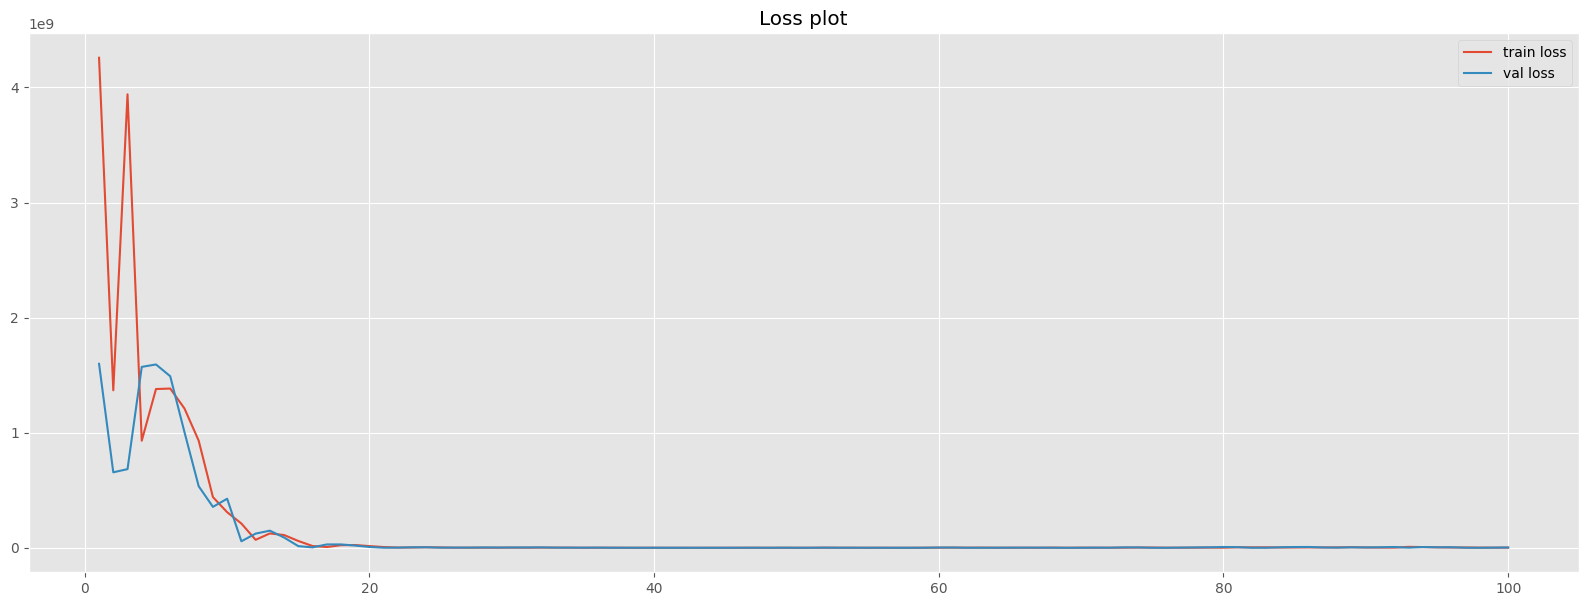

In [13]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

x = np.arange(1, num_epochs+1)
plt.figure(figsize=(20,7))
plt.plot(x, train_loss_list, label = 'train loss')
plt.plot(x ,val_loss_list, label = 'val loss')
plt.title('Loss plot')
plt.legend()
plt.show()

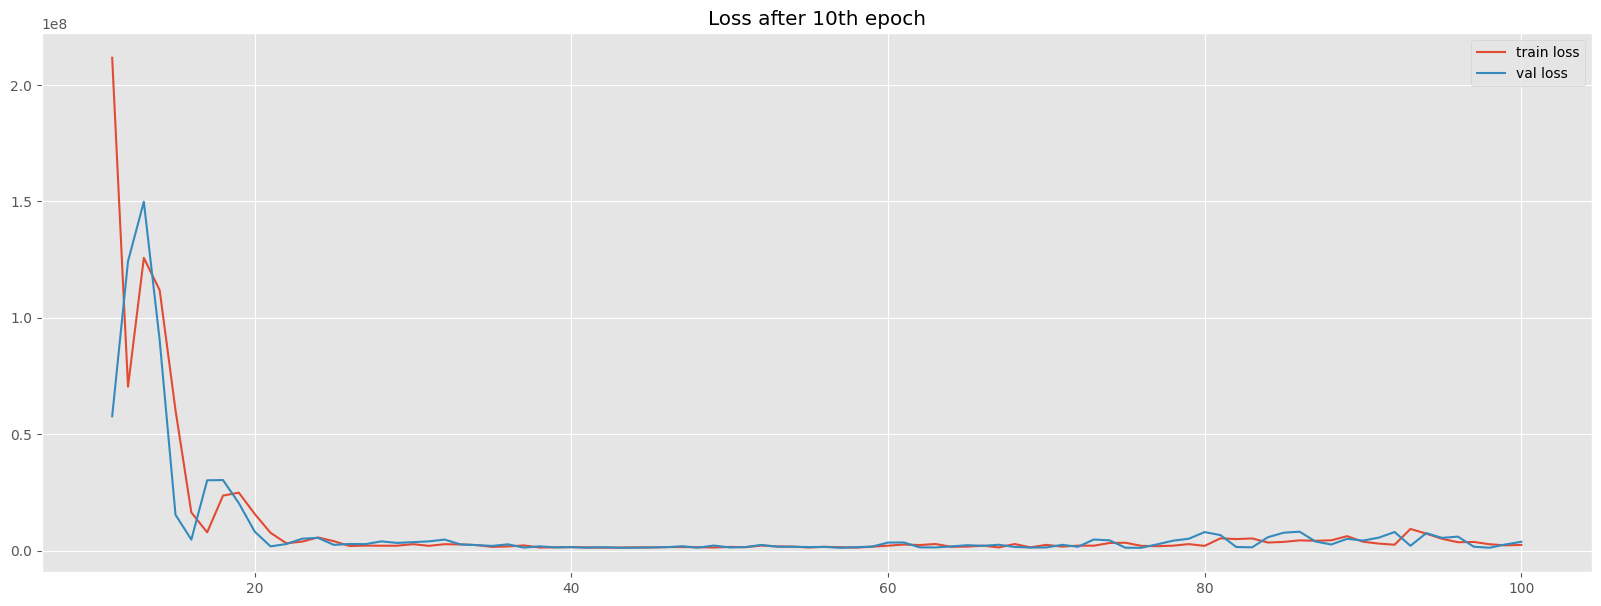

In [14]:
epoch = 10
plt.figure(figsize=(20,7))
plt.plot(x[epoch:], train_loss_list[epoch:], label = 'train loss')
plt.plot(x[epoch:] ,val_loss_list[epoch:], label = 'val loss')
plt.title(f'Loss after {epoch}th epoch')
plt.legend()
plt.show()

In [15]:
# for batch in val_loader:
#     break
# batch = batch.to(device)
# predicted = model(batch, edge_index)
# predicted.shape
# predicted_grid = predicted.reshape(num_latitudes, num_longitudes, -1)
# temp_grid = predicted_grid[:,:,0] -  273.15
# plt.imshow(temp_grid.cpu().detach().numpy())
# plt.show()

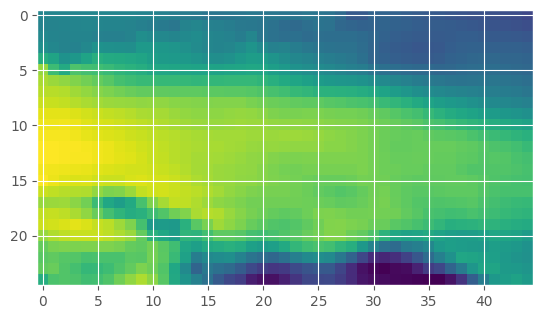

In [19]:
sample = data[0, 0, :, 0]
sample = sample.reshape((num_latitudes, num_longitudes))
plt.imshow(sample.cpu())